In [15]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from statistics import mean
from datetime import date
import file

In [16]:
# Define the ticker symbol
symbol = 'IGM'

# Get data on this ticker
tickerData = yf.Ticker(symbol)

# Get the historical prices for this ticker
history = tickerData.history(interval='1wk', start='2021-1-1', end=date.today())

In [17]:
gap = 0.5 / 100 * 100 # %

option_prices = {
    4: [94/2.6, 104/2.77, 107/2.37],
    8: [94/3.55, 107/3.47],
    9: [104/3.9],
    13: [104/4.55],
    17: [94/5.85],
    21: [107/6.7],
    26: [104/6.55],
    30: [94/7.6],
    34: [107/9.5]
}
print('option leverages:')
for w in sorted(option_prices.keys()):
    print(f'\t{w:2}w', *[f'{x:4.1f}' for x in option_prices[w]])

option_leverage = {w:mean(option_prices[w]) for w in option_prices}
# normalize values so longer expirations have lower leverage
option_leverage = {k: v for k, v in zip(sorted(option_leverage.keys()), sorted(option_leverage.values(), reverse=True))}

print('mean option leverage, break even:')
for w in sorted(option_leverage.keys()):
    print(f'\t{w:2}w {option_leverage[w]:4.1f} {gap + 100/option_leverage[w]:4.1f}%')
print(f'option gap: {gap:.2f}%')

file.save_option_leverage(symbol, option_leverage)

option leverages:
	 4w 36.2 37.5 45.1
	 8w 26.5 30.8
	 9w 26.7
	13w 22.9
	17w 16.1
	21w 16.0
	26w 15.9
	30w 12.4
	34w 11.3
mean option leverage, break even:
	 4w 39.6  3.0%
	 8w 28.7  4.0%
	 9w 26.7  4.2%
	13w 22.9  4.9%
	17w 16.1  6.7%
	21w 16.0  6.8%
	26w 15.9  6.8%
	30w 12.4  8.6%
	34w 11.3  9.4%
option gap: 0.50%


In [18]:
stock_change = [None]
option_performance = []
for weeks in range(1, 53):
    stock_changes = history['Close'].pct_change(periods=weeks) * 100
    stock_change.append(stock_changes.median())
    window_max = history['High'].rolling(window=pd.api.indexers.FixedForwardWindowIndexer(window_size=weeks)).max()

    if weeks in option_leverage:
        lvr = option_leverage[weeks]
        option_profits = ((stock_changes[weeks:] - gap) * lvr - 100).clip(lower=-100)
        mean_profit = option_profits.mean() / weeks
        median_profit = option_profits.median() / weeks
        positive_percent = (option_profits > 0).mean() * 100
        wmax = (((window_max / history['Open'] - 1) * 100 - gap) * lvr - 100).clip(lower=-100).median() - 100
        option_performance.append([weeks, mean_profit, positive_percent, wmax, median_profit])
        history[f'Option {weeks}w'] = option_profits # * 52 / weeks # annualized

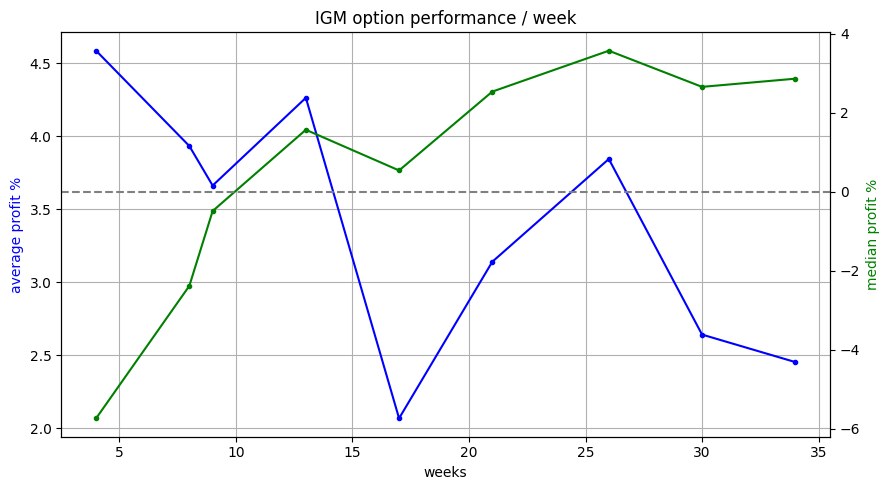

In [19]:
option_weeks = [p[0] for p in option_performance]
option_mean_profit = [p[1] for p in option_performance]
option_median_profit = [p[4] for p in option_performance]

fig, ax1 = plt.subplots(figsize=(9, 5))
ax2 = ax1.twinx()
ax1.plot(option_weeks, option_mean_profit, label='Average option profit', marker='.', color='b')
ax2.plot(option_weeks, option_median_profit, label='Median option profit', marker='.', color='g')
ax1.set_title(symbol + ' option performance / week')
ax1.set_xlabel('weeks')
ax1.set_ylabel('average profit %', color='b')
ax2.set_ylabel('median profit %', color='g')
ax2.axhline(y=0, color='grey', linestyle='--')
ax1.grid()
plt.tight_layout()
plt.show()

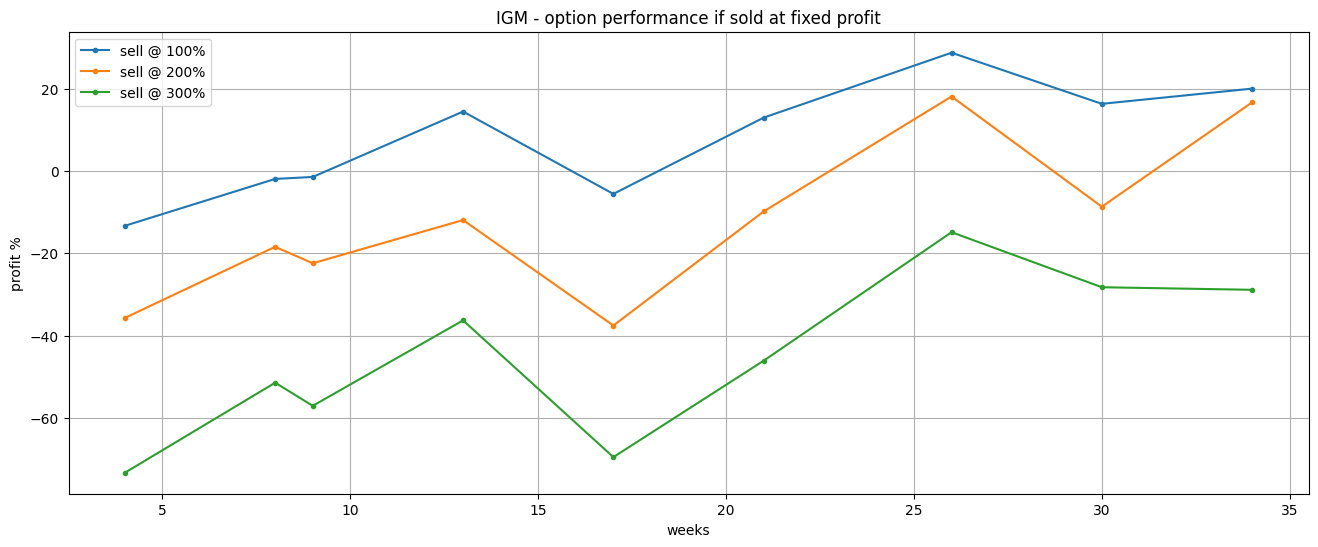

In [20]:
plt.figure(figsize=(16,6))

for percent in [100,200,300]:
    data = {}
    for weeks in option_leverage:
        lvr = option_leverage[weeks]
        window_max = history['High'].rolling(window=pd.api.indexers.FixedForwardWindowIndexer(window_size=weeks)).max()
        wmax = (((window_max / history['Open'] - 1) * 100 - gap) * lvr - 100).clip(lower=-100)
        wmax = wmax.dropna()
        q = (wmax >= percent).mean()
        # print(f'{weeks}w q:{q:.2f} wmax:', wmax.describe())
        # display(wmax)
        data[weeks] = q * (percent + 100) - 100

    # display(data)
    plt.plot(*zip(*sorted(data.items())), label=f'sell @ {percent}%', marker='.')

plt.legend(loc='best')
plt.title(f'{symbol} - option performance if sold at fixed profit')
plt.xlabel('weeks')
plt.ylabel('profit %')
plt.grid()
plt.show()

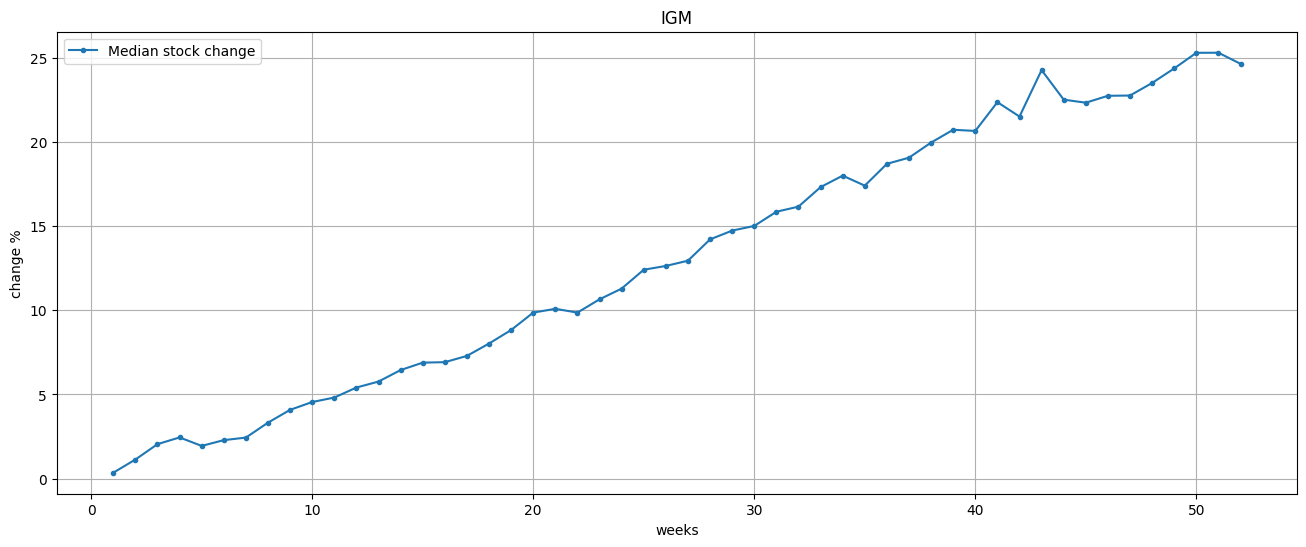

In [21]:
plt.figure(figsize=(16,6))
plt.plot(stock_change, label='Median stock change', marker='.')
plt.legend(loc='best')
plt.title(symbol)
plt.xlabel('weeks')
plt.ylabel('change %')
plt.grid()
plt.show()


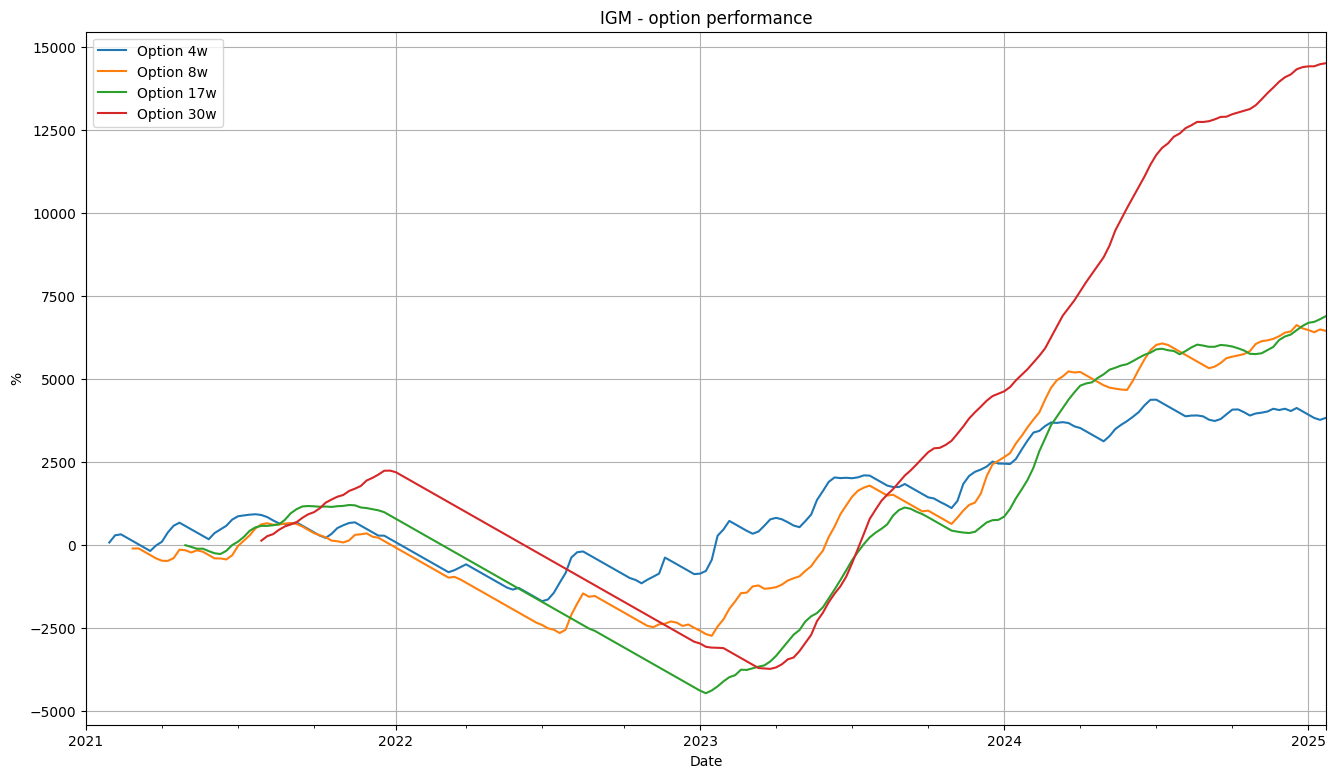

In [22]:
plt.figure(figsize=(16,9))

for w in [4,8,17,30]:
    history[f'Option {w}w'].cumsum().plot()

plt.legend()
plt.title(f'{symbol} - option performance')
plt.ylabel('%')
plt.grid()
plt.show()


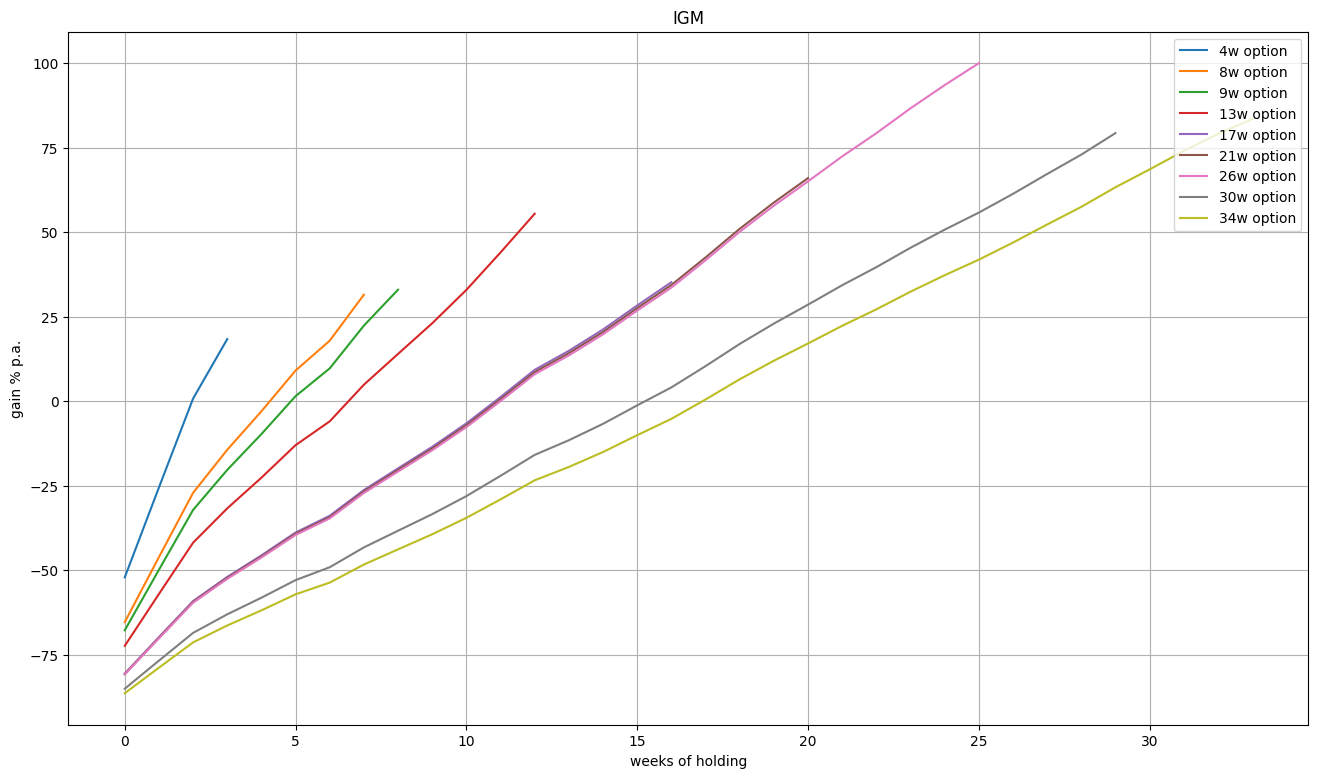

In [23]:
plt.figure(figsize=(16,9))

for w in option_leverage:
    lvr = option_leverage[w]
    gains = []
    for weeks in range(1, w+1):
        stock_changes = history['Close'].pct_change(periods=weeks) * 100
        option_profits = ((stock_changes[weeks:] - gap) * lvr - 100).clip(lower=-100)
        mean_profit = option_profits.mean() #* 52 / weeks # annualized
        gains.append(mean_profit if mean_profit > -100 else None)
    plt.plot(gains, label=f'{w}w option')
        
plt.legend(loc='upper right')
plt.title(symbol)
plt.xlabel('weeks of holding')
plt.ylabel('gain % p.a.')
plt.grid()
plt.show()